# MNIST Diffusion model 학습

## 환경설정

- PyTorch 버젼 다운그레이드 코드로 인해 세션이 자동으로 한번 꺼질 예정입니다. 다시 실행하면 됩니다.

In [1]:
# 현 CUDA 버젼 확인
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
# 파이썬 버젼 고정
import torch

# 현 PyTorch 버젼 확인
if torch.__version__.split('+')[0] != "1.11.0":
    print(f"Current PyTorch version is {torch.__version__}, downgrading to 1.11.0")

    # PyTorch 제거
    !pip uninstall torch torchvision -y

    # PyTorch 1.11.0 설치
    !pip install torch==1.11.0 torchvision==0.12.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

    # 런타임 강제 재시작
    import os
    os.kill(os.getpid(), 9)
else:
    print("PyTorch version is already 1.11.0")

ModuleNotFoundError: No module named 'torch'

In [4]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [1]:
!git clone https://github.com/shhommychon/mnist_generative_practice.git
# 실습 코드가 저장된 Github 레포지토리 클론

import sys
sys.path = ["./mnist_generative_practice"] + sys.path
# 파이썬 모듈 경로에 해당 폴더 추가(import 가능하게 설정)

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 12), reused 30 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.60 MiB | 10.13 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [6]:
# MegaTools 설치 -> MEGA 클라우드 링크에서 파일 다운로드
!apt install megatools

# mnist_feature_extractor.dth (사전학습된 MNIST Feature Extractor 다운로드)
!megadl 'https://mega.nz/file/DgUQyDyB#7Gyq_9kzCz8FcGZV659VD1Cq1_36wimGVOG2Eram3P8'

# mnist_classifier.dth (사전학습된 MNIST Classifier 다운로드)
!megadl 'https://mega.nz/file/H49S3bTI#qsonzlkV3JMniTbyzV77BB9VLhwmh1OJLTgxuD4PEMM'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 0s (1,988 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_feature_extractor.dth
Downloaded mnist_classifier.dth


## 실습 코드

#### 기본 라이브러리 import

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

### MNIST 데이터셋 다운로드 및 불러오기

- 다운로드 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#downloading-datasets)
- 불러오기 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#splitting-datasets)

#### 훈련, 검증, 테스트에 사용할 데이터셋 구성

In [7]:
# train, validation, test 데이터셋으로 분리
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
# DataLoader로 배치 처리 및 셔플 설정
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.66MB/s]

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


### 모델 및 손실함수/옵티마이저 등 설정
- 학습된 `feature_extractor`와 `classifier` 가중치 로딩
- Diffusion 모델이 생성한 이미지의 분류 정확도를 평가하기 위한 모델
- `requires_grad=False`로 설정하여 학습 중 업데이트되지 않도록 함.

In [8]:
# Diffusion model 학습 보조용 사전학습 MNIST 분류기
from models.classifier import MNISTClassifier

c_model = MNISTClassifier()
c_model.feature_extractor.load_state_dict(torch.load("mnist_feature_extractor.dth"))
c_model.classifier.load_state_dict(torch.load("mnist_classifier.dth"))

if (torch.cuda.is_available()): c_model.cuda()

# freeze
for param in c_model.parameters(): param.requires_grad = False

c_model

MNISTClassifier(
  (feature_extractor): ConvFeatExtractor(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear): Linear(in_features=3136, out_features=128, bias=True)
    (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
  )
  (classifier): ClassifierHead(
    (dropout): SoftDropout(
      (dropouts): ModuleList(
        (0-4): 5 x Dropout(p=0.5, inplace=False)
      )
    )
    (relu): ReLU()
    (linear): Linear(in_features=128, out_features=10, bias=True)
  )
)

**[`MNISTClassifier` 구조]**

(1) `feature_extractor`: Convolutional Backbone
- Conv 레이어 2개 + MaxPooling으로 특성 추출

- 이미지 크기 변화:
    - 28×28 → conv1 → 28×28 → conv2 → 28×28 → maxpool → 14×14
    - 총 feature map: 64 × 14 × 14 = 12,544 → FC: 128개로 줄임

- Dropout & BatchNorm으로 regularization

(2) `classifier`: Fully Connected Head
- `SoftDropout`: 여러 번 dropout을 적용해 성능 향상 시도

- 마지막 Linear로 10개 클래스(숫자 0~9) 분류

- Diffusion 모델 로딩 및 CUDA 적용
- 이미지에 노이즈를 점진적으로 추가하거나, 노이즈로부터 이미지를 복원하는 역할


In [9]:
from models.diffusion import MNISTDiffusion

model = MNISTDiffusion()

if (torch.cuda.is_available()): model.cuda()

model

MNISTDiffusion(
  (label_emb): Embedding(10, 32)
  (linear): Linear(in_features=816, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

**[MNISTDiffusion]**
- 클래스 조건(class-conditioned) 생성 모델.

    - 클래스 라벨은 Embedding(10, 32)을 통해 벡터화

    - 임베딩된 벡터 + 노이즈 이미지 → 하나의 벡터(816차원)로 결합

    - 이후 선형 변환 → 784차원 (28x28) 이미지 벡터로 reshape

    - CNN 블록 (Conv2D → Conv2D → Conv2D)으로 denoising 수행

- Forward/Backward
    - Forward: 노이즈 추가

    - Backward: 라벨을 조건으로 주고 노이즈 → 이미지 복원

- 픽셀 기반 손실 + 분류 손실 혼합하여 학습
- 학습률 스케줄러, early stopping 등 포함하여 전체 학습 전략 구성

In [10]:
pixelwise_loss = nn.L1Loss()
classification_loss = nn.CrossEntropyLoss()

lr=0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

decay_rate = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

max_epochs = 100
best_val_loss = 100
max_patience = 5

### 이미지 생성 코드

- 학습 중간 확인 용도
- Diffusion 모델을 이용해 노이즈 → 이미지로 복원하는 함수
- 클래스 조건(class conditioning)을 사용하여 지정한 숫자 이미지 생성

In [11]:
def generate_images(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        for _ in range(model.num_steps):
            noise = model(noise, class_label)
        recon_image = noise.clone()

    return recon_image

### 모델 학습 코드
- Forward: 이미지에 점진적으로 노이즈를 추가

- Backward: 노이즈에서 이미지를 복원하며 픽셀 손실 + 분류 손실 계산

- 일정 epoch 동안 성능 향상이 없으면 조기 종료

- 주기적으로 생성 이미지 시각화 및 모델 저장


Epoch: 1/100,
	Train Loss: 1.38979755
		classification loss: 1.48982721
		pixelwise loss: 1.35255187
	Val Loss: 2.31434181
		classification loss: 2.94911835
		pixelwise loss: 2.24061385


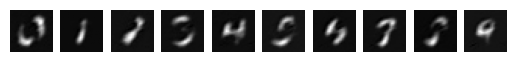

	Saving the model state dictionary for Epoch: 1 with Validation loss: 2.31434181

Epoch: 2/100,
	Train Loss: 0.87633330
		classification loss: 0.55927625
		pixelwise loss: 0.86235139
	Val Loss: 1.20295603
		classification loss: 0.95885878
		pixelwise loss: 1.17898456


<Figure size 640x480 with 0 Axes>

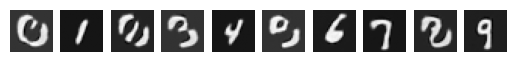

	Saving the model state dictionary for Epoch: 2 with Validation loss: 1.20295603

Epoch: 3/100,
	Train Loss: 0.82327332
		classification loss: 0.58321539
		pixelwise loss: 0.80869293
	Val Loss: 1.15970865
		classification loss: 0.61952637
		pixelwise loss: 1.14422049


<Figure size 640x480 with 0 Axes>

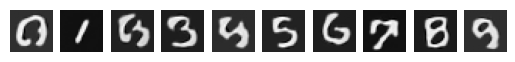

	Saving the model state dictionary for Epoch: 3 with Validation loss: 1.15970865

Epoch: 4/100,
	Train Loss: 0.81381308
		classification loss: 0.58281720
		pixelwise loss: 0.79924265
	Val Loss: 1.16693351
		classification loss: 0.62909736
		pixelwise loss: 1.15120608


<Figure size 640x480 with 0 Axes>

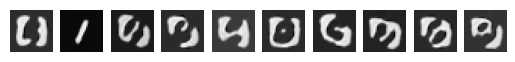

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 5/100,
	Train Loss: 0.80801504
		classification loss: 0.57567009
		pixelwise loss: 0.79362329
	Val Loss: 1.17216605
		classification loss: 0.67988116
		pixelwise loss: 1.15516902


<Figure size 640x480 with 0 Axes>

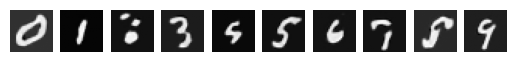

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 6/100,
	Train Loss: 0.80581431
		classification loss: 0.57461111
		pixelwise loss: 0.79144903
	Val Loss: 1.15626660
		classification loss: 0.51598606
		pixelwise loss: 1.14336695


<Figure size 640x480 with 0 Axes>

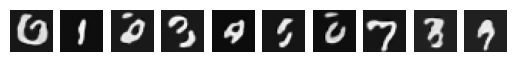

	Saving the model state dictionary for Epoch: 6 with Validation loss: 1.15626660

Epoch: 7/100,
	Train Loss: 0.80135826
		classification loss: 0.56961637
		pixelwise loss: 0.78711785
	Val Loss: 1.15156159
		classification loss: 0.47408533
		pixelwise loss: 1.13970945


<Figure size 640x480 with 0 Axes>

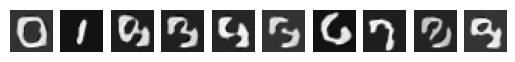

	Saving the model state dictionary for Epoch: 7 with Validation loss: 1.15156159

Epoch: 8/100,
	Train Loss: 0.80100914
		classification loss: 0.56284477
		pixelwise loss: 0.78693802
	Val Loss: 1.13906238
		classification loss: 0.42910942
		pixelwise loss: 1.12833464


<Figure size 640x480 with 0 Axes>

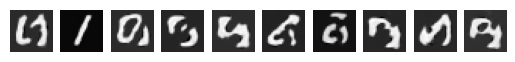

	Saving the model state dictionary for Epoch: 8 with Validation loss: 1.13906238

Epoch: 9/100,
	Train Loss: 0.79649161
		classification loss: 0.55797442
		pixelwise loss: 0.78254225
	Val Loss: 1.15062117
		classification loss: 0.39663110
		pixelwise loss: 1.14070539


<Figure size 640x480 with 0 Axes>

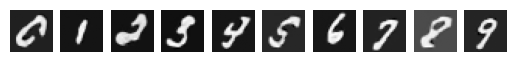

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 10/100,
	Train Loss: 0.79472372
		classification loss: 0.55113341
		pixelwise loss: 0.78094539
	Val Loss: 1.13006363
		classification loss: 0.48639628
		pixelwise loss: 1.11790372


<Figure size 640x480 with 0 Axes>

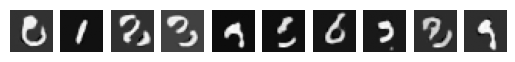

	Saving the model state dictionary for Epoch: 10 with Validation loss: 1.13006363

Epoch: 11/100,
	Train Loss: 0.79250096
		classification loss: 0.54286199
		pixelwise loss: 0.77892941
	Val Loss: 1.12499407
		classification loss: 0.33893401
		pixelwise loss: 1.11652072


<Figure size 640x480 with 0 Axes>

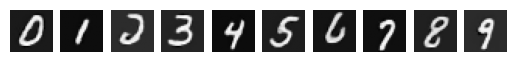

	Saving the model state dictionary for Epoch: 11 with Validation loss: 1.12499407

Epoch: 12/100,
	Train Loss: 0.79007277
		classification loss: 0.53877239
		pixelwise loss: 0.77660346
	Val Loss: 1.13540458
		classification loss: 0.36254531
		pixelwise loss: 1.12634095


<Figure size 640x480 with 0 Axes>

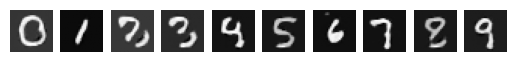

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 13/100,
	Train Loss: 0.78821499
		classification loss: 0.53045682
		pixelwise loss: 0.77495357
	Val Loss: 1.12714356
		classification loss: 0.31655889
		pixelwise loss: 1.11922959


<Figure size 640x480 with 0 Axes>

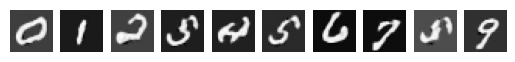

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 14/100,
	Train Loss: 0.78515069
		classification loss: 0.52447815
		pixelwise loss: 0.77203873
	Val Loss: 1.12331201
		classification loss: 0.29414294
		pixelwise loss: 1.11595844


<Figure size 640x480 with 0 Axes>

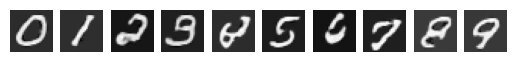

	Saving the model state dictionary for Epoch: 14 with Validation loss: 1.12331201

Epoch: 15/100,
	Train Loss: 0.78428700
		classification loss: 0.51850814
		pixelwise loss: 0.77132430
	Val Loss: 1.12136288
		classification loss: 0.31084568
		pixelwise loss: 1.11359174


<Figure size 640x480 with 0 Axes>

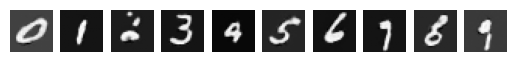

	Saving the model state dictionary for Epoch: 15 with Validation loss: 1.12136288

Epoch: 16/100,
	Train Loss: 0.78147686
		classification loss: 0.51278403
		pixelwise loss: 0.76865726
	Val Loss: 1.10870006
		classification loss: 0.34332246
		pixelwise loss: 1.10011700


<Figure size 640x480 with 0 Axes>

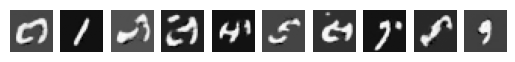

	Saving the model state dictionary for Epoch: 16 with Validation loss: 1.10870006

Epoch: 17/100,
	Train Loss: 0.77878199
		classification loss: 0.50763115
		pixelwise loss: 0.76609121
	Val Loss: 1.11195476
		classification loss: 0.29041888
		pixelwise loss: 1.10469428


<Figure size 640x480 with 0 Axes>

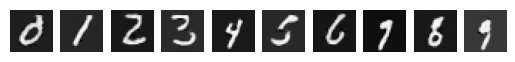

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 18/100,
	Train Loss: 0.77692267
		classification loss: 0.50212977
		pixelwise loss: 0.76436943
	Val Loss: 1.12165741
		classification loss: 0.31246319
		pixelwise loss: 1.11384583


<Figure size 640x480 with 0 Axes>

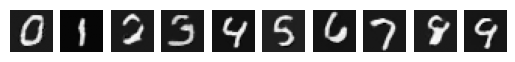

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 19/100,
	Train Loss: 0.77624019
		classification loss: 0.49642183
		pixelwise loss: 0.76382965
	Val Loss: 1.10451130
		classification loss: 0.19680308
		pixelwise loss: 1.09959123


<Figure size 640x480 with 0 Axes>

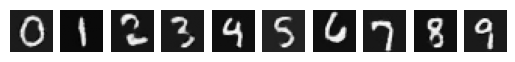

	Saving the model state dictionary for Epoch: 19 with Validation loss: 1.10451130

Epoch: 20/100,
	Train Loss: 0.77357004
		classification loss: 0.49671021
		pixelwise loss: 0.76115228
	Val Loss: 1.10292073
		classification loss: 0.25512657
		pixelwise loss: 1.09654257


<Figure size 640x480 with 0 Axes>

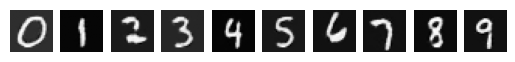

	Saving the model state dictionary for Epoch: 20 with Validation loss: 1.10292073

Epoch: 21/100,
	Train Loss: 0.77181202
		classification loss: 0.48899347
		pixelwise loss: 0.75958719
	Val Loss: 1.10481688
		classification loss: 0.27186086
		pixelwise loss: 1.09802036


<Figure size 640x480 with 0 Axes>

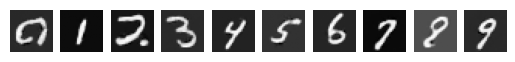

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 22/100,
	Train Loss: 0.76996214
		classification loss: 0.48717125
		pixelwise loss: 0.75778285
	Val Loss: 1.09946940
		classification loss: 0.21786065
		pixelwise loss: 1.09402289


<Figure size 640x480 with 0 Axes>

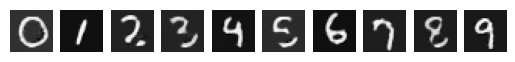

	Saving the model state dictionary for Epoch: 22 with Validation loss: 1.09946940

Epoch: 23/100,
	Train Loss: 0.76941314
		classification loss: 0.48608736
		pixelwise loss: 0.75726095
	Val Loss: 1.09275683
		classification loss: 0.23014146
		pixelwise loss: 1.08700329


<Figure size 640x480 with 0 Axes>

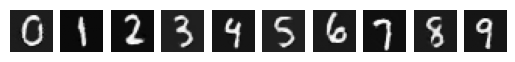

	Saving the model state dictionary for Epoch: 23 with Validation loss: 1.09275683

Epoch: 24/100,
	Train Loss: 0.76685478
		classification loss: 0.48050627
		pixelwise loss: 0.75484212
	Val Loss: 1.08991266
		classification loss: 0.31498663
		pixelwise loss: 1.08203799


<Figure size 640x480 with 0 Axes>

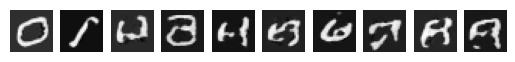

	Saving the model state dictionary for Epoch: 24 with Validation loss: 1.08991266

Epoch: 25/100,
	Train Loss: 0.76656668
		classification loss: 0.48019536
		pixelwise loss: 0.75456179
	Val Loss: 1.08931993
		classification loss: 0.28739972
		pixelwise loss: 1.08213493


<Figure size 640x480 with 0 Axes>

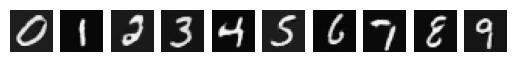

	Saving the model state dictionary for Epoch: 25 with Validation loss: 1.08931993

Epoch: 26/100,
	Train Loss: 0.76435498
		classification loss: 0.47834858
		pixelwise loss: 0.75239626
	Val Loss: 1.09990148
		classification loss: 0.23900596
		pixelwise loss: 1.09392633


<Figure size 640x480 with 0 Axes>

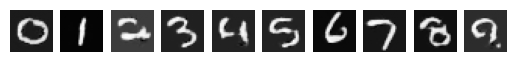

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 27/100,
	Train Loss: 0.76289701
		classification loss: 0.47545155
		pixelwise loss: 0.75101072
	Val Loss: 1.09308135
		classification loss: 0.24686792
		pixelwise loss: 1.08690965


<Figure size 640x480 with 0 Axes>

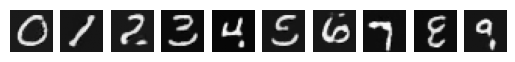

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 28/100,
	Train Loss: 0.76156505
		classification loss: 0.47246534
		pixelwise loss: 0.74975342
	Val Loss: 1.09681773
		classification loss: 0.28779137
		pixelwise loss: 1.08962295


<Figure size 640x480 with 0 Axes>

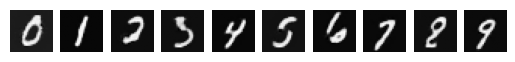

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 29/100,
	Train Loss: 0.75890354
		classification loss: 0.47276758
		pixelwise loss: 0.74708435
	Val Loss: 1.08389279
		classification loss: 0.19685450
		pixelwise loss: 1.07897142


<Figure size 640x480 with 0 Axes>

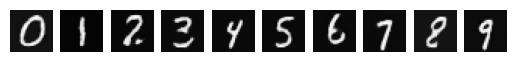

	Saving the model state dictionary for Epoch: 29 with Validation loss: 1.08389279

Epoch: 30/100,
	Train Loss: 0.76089622
		classification loss: 0.47119363
		pixelwise loss: 0.74911638
	Val Loss: 1.08485346
		classification loss: 0.27156167
		pixelwise loss: 1.07806442


<Figure size 640x480 with 0 Axes>

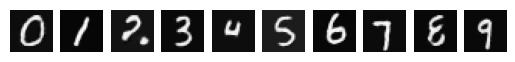

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 31/100,
	Train Loss: 0.75809391
		classification loss: 0.46863096
		pixelwise loss: 0.74637814
	Val Loss: 1.09353604
		classification loss: 0.33504953
		pixelwise loss: 1.08515980


<Figure size 640x480 with 0 Axes>

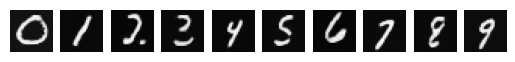

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 32/100,
	Train Loss: 0.75729745
		classification loss: 0.46865544
		pixelwise loss: 0.74558107
	Val Loss: 1.08747945
		classification loss: 0.28405507
		pixelwise loss: 1.08037808


<Figure size 640x480 with 0 Axes>

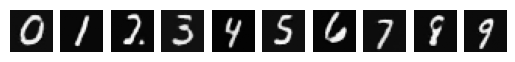

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 33/100,
	Train Loss: 0.75611667
		classification loss: 0.46477225
		pixelwise loss: 0.74449736
	Val Loss: 1.08550376
		classification loss: 0.23698863
		pixelwise loss: 1.07957904


<Figure size 640x480 with 0 Axes>

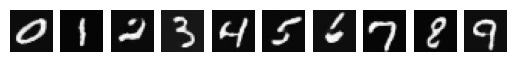

	Loss not decreased. Will wait for 1 more epochs...

Epoch: 34/100,
	Train Loss: 0.75524213
		classification loss: 0.46561842
		pixelwise loss: 0.74360167
	Val Loss: 1.09283487
		classification loss: 0.31535450
		pixelwise loss: 1.08495101


<Figure size 640x480 with 0 Axes>

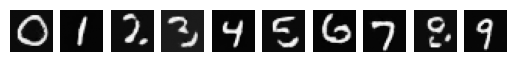

	Loss not decreased. Will wait for 0 more epochs...


<Figure size 640x480 with 0 Axes>

In [12]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"
patience = max_patience
for epoch in range(max_epochs):
    total_train_loss = {
        "loss_class": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }
    total_val_loss = {
        "loss_class": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }

    model.train()

    # training
    for iter, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)

        # Forward diffusion process
        noisy_images = [image.clone()]
        noisy_image = image.clone()
        for _ in range(model.num_steps):
            noisy_image = model(noisy_image, backward=False)
            noisy_images.append(noisy_image.clone())

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward diffusion process
        recon_image = noisy_images.pop()
        train_pixel_loss = torch.tensor(0.).to(device)
        train_class_loss = torch.tensor(0.).to(device)
        for _ in range(model.num_steps):
            recon_image = model(recon_image, label)
            train_pixel_loss += pixelwise_loss(recon_image, image) # noisy_images[-1])
            class_pred = c_model(recon_image)
            train_class_loss += classification_loss(class_pred, label)
            recon_image = noisy_images.pop()

        # loss computation and backpropagation
        this_train_loss = train_pixel_loss + 0.025 * train_class_loss
        this_train_loss.backward()

        # Update diffusion model parameters
        optimizer.step()

        total_train_loss["loss_class"] += train_class_loss.item()
        total_train_loss["loss_pixel"] += train_pixel_loss.item()
        total_train_loss["loss_total"] += this_train_loss.item()

    # Step the learning rate schedulers
    scheduler.step()

    total_train_loss = { k: train_loss / (iter + 1) for k, train_loss
                                                in total_train_loss.items() }

    # validation
    model.eval()

    for iter, (image, label) in enumerate(val_dataloader):
        image = image.to(device)
        label = label.to(device)

        # Forward diffusion process
        noisy_images = [image.clone()]
        noisy_image = image.clone()
        for _ in range(model.num_steps):
            noisy_image = model(noisy_image, backward=False)
            noisy_images.append(noisy_image.clone())

        # Backward diffusion process
        recon_image = noisy_images.pop()
        val_pixel_loss = torch.tensor(0.).to(device)
        val_class_loss = torch.tensor(0.).to(device)
        for _ in range(model.num_steps):
            recon_image = model(recon_image, label)
            val_pixel_loss += pixelwise_loss(recon_image, image) # noisy_images[-1])
            class_pred = c_model(recon_image)
            val_class_loss += classification_loss(class_pred, label)
            _ = noisy_images.pop()

        total_val_loss["loss_class"] += val_class_loss.item()
        total_val_loss["loss_pixel"] += val_pixel_loss.item()
        total_val_loss["loss_total"] += (val_pixel_loss + 0.025 * val_class_loss).item()

    total_val_loss = { k: val_loss / (iter + 1) for k, val_loss
                                                in total_val_loss.items() }

    print(f"\nEpoch: {epoch+1}/{max_epochs},"
          f"\n\tTrain Loss: {total_train_loss['loss_total']:.8f}"
          f"\n\t\tclassification loss: {total_train_loss['loss_class']:.8f}"
          f"\n\t\tpixelwise loss: {total_train_loss['loss_pixel']:.8f}"
          f"\n\tVal Loss: {total_val_loss['loss_total']:.8f}"
          f"\n\t\tclassification loss: {total_val_loss['loss_class']:.8f}"
          f"\n\t\tpixelwise loss: {total_val_loss['loss_pixel']:.8f}")

    noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
    class_label = torch.tensor([ n for n in range(10) ]).to(device)
    result = generate_images(model, noise, class_label).cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=10)
    for i, image in enumerate(result):
        plt.subplot(1, 10, i+1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
    plt.clf()

    if total_val_loss["loss_total"] < best_val_loss:
        best_val_loss = total_val_loss["loss_total"]
        print(f"\tSaving the model state dictionary for Epoch: {epoch+1} with Validation loss: {best_val_loss:.8f}")
        torch.save(model.state_dict(), "mnist_diffusion.dth")
        patience = max_patience
    else:
        patience -= 1
        print(f"\tLoss not decreased. Will wait for {patience} more epochs...")

    if patience <= 0: break


### 사전학습 모델 불러오기

- 위 모델 학습 코드를 실행하기 귀찮을 경우에만 이 셀을 실행

In [13]:
!apt install megatools

# mnist_diffusion.dth
!megadl 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

ERROR: Download failed for 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4': Can't rename donwloaded temporary file /content/.megatmp.Sg90lRhQ to /content/mnist_diffusion.dth (downloaded data are good!): Error moving file /content/.megatmp.Sg90lRhQ: File exists


### 학습 모델 테스트

#### 일반 이미지 생성
- 저장된 DDPM 모델 파라미터 불러와서 평가 준비

In [14]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth"))

if (torch.cuda.is_available()): model.cuda()

model.eval()

MNISTDiffusion(
  (label_emb): Embedding(10, 32)
  (linear): Linear(in_features=816, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

### 이미지 생성 및 시각화(원본 vs 생성 이미지 비교)
- MNIST 테스트셋의 실제 숫자 이미지 0~9 하나씩 수집

- 같은 조건(noise, label)으로 여러 번 이미지를 생성하여 다양성 비교

- 원본 이미지와 함께 Diffusion이 생성한 이미지들을 시각화하여 성능 평가

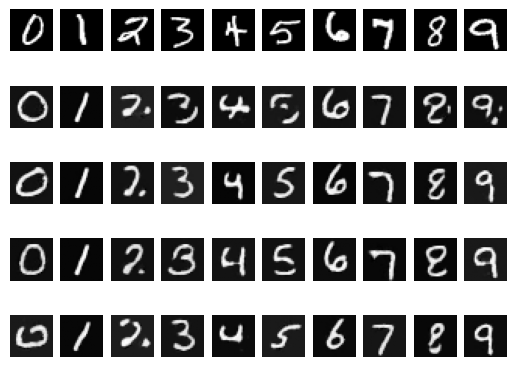

In [15]:
# MNIST 데이터셋 실제 샘플들 및 생성 결과들 저장

original = [ None for _ in range(10) ]

# store original image examples
stop = False
for iter, (image_batch, label_batch) in enumerate(test_dataloader):
    for image, label in zip(image_batch, label_batch):

        label = label.item()

        if original[label] is None:
            original[label] = image.data

        if None not in original:
            stop = True
            break

    if stop: break

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result1 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 1

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result2 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 2

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result3 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 3

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result4 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 4


# MNIST 데이터셋 실제 샘플들 및 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=5, ncols=10)

for i, image in enumerate(original):
    plt.subplot(5, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result1):
    plt.subplot(5, 10, 2*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result2):
    plt.subplot(5, 10, 3*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result3):
    plt.subplot(5, 10, 4*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result4):
    plt.subplot(5, 10, 5*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

plt.show()

#### 이미지 생성 단계별 확인
- DDPM 모델이 이미지를 생성하는 과정에서 각 스텝별 결과를 저장하고 시각화하기 위해 사용되는 함수
- 모든 복원 단계를 추적함.
- 11행: 1행은 원본 이미지, 2~11행은 복원된 이미지
- `generate_images2`를 통해 얻은 스텝별 이미지를 각 행(row)에 출력

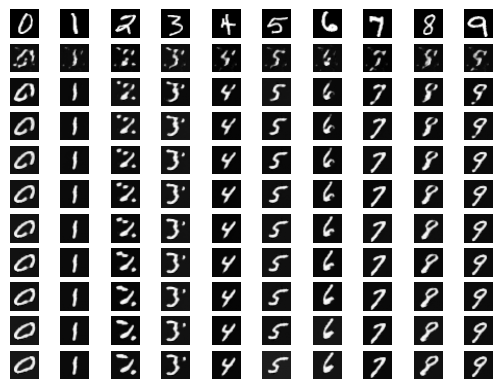

In [16]:
def generate_images2(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        recon_images = list()
        for _ in range(model.num_steps):
            noise = model(noise, class_label)
            recon_images.append(noise.view(class_label.size(0), 1, 28, 28).cpu().detach().numpy())

    return recon_images

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([ n for n in range(10) ]).to(device)
results = np.array(generate_images2(model, noise, class_label))


# MNIST 데이터셋 실제 샘플들, Diffusion step별 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=11, ncols=10)

for i, image in enumerate(original):
    plt.subplot(11, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for j, result in enumerate(results):
    for i, image in enumerate(result):
        plt.subplot(11, 10, (j+2)*10-(9-i))
        plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
        plt.axis("off")

plt.show()